In [ ]:
!git clone https://github.com/ndb796/Face-Mask-Classification-20000-Dataset

Cloning into 'Face-Mask-Classification-20000-Dataset'...
remote: Enumerating objects: 20017, done.
remote: Total 20017 (delta 0), reused 0 (delta 0), pack-reused 20017
Receiving objects: 100% (20017/20017), 600.78 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (20001/20001), done.


In [ ]:
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

이미지 크기: (224, 224)


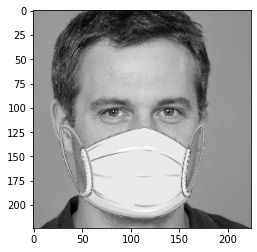

이미지 크기: (224, 224)


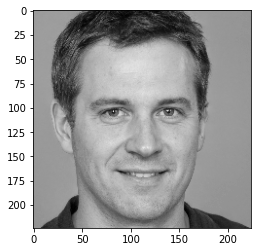

In [ ]:
#학습할 이미지중 쓴거 출력 
image = Image.open('./Face-Mask-Classification-20000-Dataset/train/with_mask/with-mask-default-mask-seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap ='gray')
plt.show()

#안쓴거 출력
image = Image.open('./Face-Mask-Classification-20000-Dataset/train/without_mask/seed0030.png')
print("이미지 크기:", image.size)

plt.imshow(image, cmap='gray')
plt.show()

데이터셋 불러오기

In [ ]:
transforms_train = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

data_dir =  './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir,'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size =64, shuffle =True, num_workers=2)
print('Train dataset size: ', len(train_dataset))

class_names = train_dataset.classes
print('Class names : ', class_names)

Train dataset size:  18000
Class names :  ['with_mask', 'without_mask']


In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
n_classes=2
latent_dim=100
# 생성자(Generator) 클래스 정의
class CustomGenerator(nn.Module):
    def __init__(self):
        super(CustomGenerator, self).__init__()
        # 레이블 정보를 매핑
        self.label_embed = nn.Embedding(n_classes, n_classes)

        self.init_size = 4 #원본 크기보다 16배 작은값으로 초기화
        #초기 채널의 크기는 512
        self.layer1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 512 * self.init_size * self.init_size)) 

        #cov block
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(512),#채널의 크기와 동일
            nn.Upsample(scale_factor=2), #너비와 높이 2배씩 증가
            nn.Conv2d(512,512, kernel_size =3, stride =1, padding =1 ), #너비 높이 유지
            nn.BatchNorm2d(512,0.8),
            nn.LeakyReLU(0.2, inplace = True),

                        nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256으로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 3으로
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        # 노이즈(noise) 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        inputs = torch.cat((noise, self.label_embed(labels)), -1)
        output = self.layer1(inputs)
        output = output.view(output.size(0), 512, self.init_size, self.init_size)
        output = self.conv_blocks(output)
        return output


# 판별자(Discriminator) 클래스 정의
class CustomDiscriminator(nn.Module):
    def __init__(self):
        super(CustomDiscriminator, self).__init__()
        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(2, 32, bn=False),
            *make_block(32, 64),
            *make_block(64, 128),
            *make_block(128, 256),
            *make_block(256, 512),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1),
            nn.Sigmoid()
        )

        # 레이블 정보를 임베딩 차원으로 매핑하여 사용
        self.label_embed = nn.Embedding(n_classes, 1 * 64 * 64)

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img, labels):
        # 이미지 벡터와 레이블 임베딩을 순차적으로 연결하여 입력
        embed = self.label_embed(labels).view((img.size(0), 1, 64, 64))
        inputs = torch.cat((img, embed), 1)
        output = self.conv_blocks(inputs)
        output = output.view(output.size(0), -1)
        output = self.classifier(output)
        return output

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
customgan_generator = CustomGenerator()
customgan_discriminator = CustomDiscriminator()

customgan_generator.cuda()
customgan_discriminator.cuda()

# 가중치(weights) 초기화
customgan_generator.apply(weights_init_normal)
customgan_discriminator.apply(weights_init_normal)

# 손실 함수(loss function)
adversarial_loss = nn.MSELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(customgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(customgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# 모델 학습하는 코드 작성
!mkdir -p ./results/customgan/

n_epochs = 100 # 학습의 횟수(epoch) 설정
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        generated_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        generated_imgs = customgan_generator(z, generated_labels)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(customgan_discriminator(generated_imgs, generated_labels), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(customgan_discriminator(real_imgs, labels), real)
        fake_loss = adversarial_loss(customgan_discriminator(generated_imgs.detach(), generated_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = customgan_generator(z, labels)
            save_image(generated_imgs, f"./results/customgan/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/100] [D loss: 0.251216] [G loss: 0.269813] [Elapsed time: 24.55s]
[Epoch 1/100] [D loss: 0.248325] [G loss: 0.251239] [Elapsed time: 48.55s]
[Epoch 2/100] [D loss: 0.250101] [G loss: 0.250630] [Elapsed time: 72.94s]
[Epoch 3/100] [D loss: 0.250360] [G loss: 0.254335] [Elapsed time: 97.23s]
[Epoch 4/100] [D loss: 0.250200] [G loss: 0.252361] [Elapsed time: 121.46s]
[Epoch 5/100] [D loss: 0.245202] [G loss: 0.244267] [Elapsed time: 146.44s]
[Epoch 6/100] [D loss: 0.256588] [G loss: 0.251002] [Elapsed time: 170.86s]
[Epoch 7/100] [D loss: 0.241486] [G loss: 0.241157] [Elapsed time: 195.23s]
[Epoch 8/100] [D loss: 0.256229] [G loss: 0.264499] [Elapsed time: 219.58s]
[Epoch 9/100] [D loss: 0.243533] [G loss: 0.250114] [Elapsed time: 244.00s]
[Epoch 10/100] [D loss: 0.248172] [G loss: 0.253615] [Elapsed time: 268.39s]
[Epoch 11/100] [D loss: 0.251764] [G loss: 0.238101] [Elapsed time: 292.89s]
[Epoch 12/100] [D loss: 0.247911] [G loss: 0.258873] [Elapsed time: 317.45s]
[Epoch 13/100

KeyboardInterrupt: ignored

In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 32

In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

python3: can't open file './pytorch-frechet-inception-distance/fid.py': [Errno 2] No such file or directory


In [ ]:
# 평가 수행
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/custom/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 32

python3: can't open file './pytorch-frechet-inception-distance/fid.py': [Errno 2] No such file or directory


In [ ]:
# Google Colab으로부터 results.zip 압축 파일 다운로드
from google.colab import files

files.download('./results.zip')